**Identifiers & Metadata**

application_id: A unique identifier for each individual loan application.

customer_id: A unique identifier for each customer. A single customer may have multiple applications.

application_date: The date on which the loan application was submitted.

data_batch_id: An identifier for the data processing batch this record belongs to.

**Loan Characteristics**

loan_amount_requested: The principal amount of the loan requested by the applicant.

loan_amount_usd: The requested loan amount converted to US Dollars for standardization.

loan_tenure_months: The duration of the loan repayment period in months.

interest_rate_offered: The annual interest rate offered for the loan.

purpose_of_loan: The stated reason for seeking the loan.

loan_type_*: A set of binary columns indicating the specific type of loan product.

**Applicant Financial Profile**

employment_status: The applicant's current employment situation.

monthly_income: The applicant's stated gross monthly income.

yearly_income: The applicant's stated gross annual income.

annual_bonus: The applicant's declared annual bonus amount.

cibil_score: A credit score (e.g., from CIBIL) representing the applicant's creditworthiness and history. Higher scores indicate better credit health.

existing_emis_monthly: The total amount of Equated Monthly Installments (EMIs) the applicant is currently paying for other existing loans.

debt_to_income_ratio: This ratio helps assess an applicant's ability to manage monthly payments.

credit_utilization_ratio: The ratio of the applicant's outstanding credit card debt to their total credit card limit.

**Applicant Demographics & Personal Information**

applicant_age: The age of the applicant in years at the time of application.

gender_*: A set of one-hot encoded binary columns representing the applicant's gender.

property_ownership_status: The applicant's housing situation.

residential_address: The applicant's provided residential address (likely anonymized or generalized).

number_of_dependents: The number of people financially dependent on the applicant.

**Target Variable**

fraud_flag: This is the key target variable for prediction. It's a binary indicator where 1 signifies a fraudulent application and 0 signifies a legitimate application.

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import chi2_contingency
import numpy as np

In [122]:
df = pd.read_csv('train.csv')
df.head()

,Unnamed: 0,application_id,customer_id,application_date,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,...,loan_type_Home Loan,loan_type_Personal Loan,gender_Male,gender_Other,yearly_income,loan_amount_usd,credit_utilization_ratio,annual_bonus,data_batch_id,fraud_flag
0,1363,acde818b-d1cc-4da4-9858-c2155ee2be85,CUST102632,2025-02-19,100000.0,60,11.27,Vehicle Purchase,Self-Employed,NaN,...,0,0,0,0,658800.0,108000.0,0.424338,611.79,batch_20250926_A,0
1,45780,75ab4a03-0d02-4ee4-9840-97486f64ec9e,CUST109462,2024-02-09,551000.0,360,12.14,Vehicle Purchase,Retired,47600.0,...,0,1,1,0,571200.0,595080.0,0.387727,300.12,batch_20250926_A,1
2,48716,f1170d68-b793-46e2-835a-2c1d58be9d9d,CUST105157,2025-05-10,440000.0,240,12.26,Business Expansion,Self-Employed,NaN,...,1,0,0,0,1476000.0,475200.0,0.363311,195884.39,batch_20250926_A,0
3,44109,2ccd4175-9bee-464f-b321-22645c778d8e,CUST103892,2024-09-09,1075000.0,12,12.77,Wedding,Business Owner,30000.0,...,0,0,0,0,360000.0,1161000.0,0.743246,9669.89,batch_20250926_A,0
4,13333,645a4f5b-3382-4624-8496-801147ca1bc3,CUST114147,2023-10-14,379000.0,120,10.56,Wedding,Retired,109800.0,...,0,0,0,1,1317600.0,409320.0,0.442568,1646.28,batch_20250926_A,0


In [123]:
df = df.drop(columns=['Unnamed: 0']) ##removing first column, that looks just an random id
df.head()

,application_id,customer_id,application_date,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,...,loan_type_Home Loan,loan_type_Personal Loan,gender_Male,gender_Other,yearly_income,loan_amount_usd,credit_utilization_ratio,annual_bonus,data_batch_id,fraud_flag
0,acde818b-d1cc-4da4-9858-c2155ee2be85,CUST102632,2025-02-19,100000.0,60,11.27,Vehicle Purchase,Self-Employed,NaN,633,...,0,0,0,0,658800.0,108000.0,0.424338,611.79,batch_20250926_A,0
1,75ab4a03-0d02-4ee4-9840-97486f64ec9e,CUST109462,2024-02-09,551000.0,360,12.14,Vehicle Purchase,Retired,47600.0,705,...,0,1,1,0,571200.0,595080.0,0.387727,300.12,batch_20250926_A,1
2,f1170d68-b793-46e2-835a-2c1d58be9d9d,CUST105157,2025-05-10,440000.0,240,12.26,Business Expansion,Self-Employed,NaN,750,...,1,0,0,0,1476000.0,475200.0,0.363311,195884.39,batch_20250926_A,0
3,2ccd4175-9bee-464f-b321-22645c778d8e,CUST103892,2024-09-09,1075000.0,12,12.77,Wedding,Business Owner,30000.0,732,...,0,0,0,0,360000.0,1161000.0,0.743246,9669.89,batch_20250926_A,0
4,645a4f5b-3382-4624-8496-801147ca1bc3,CUST114147,2023-10-14,379000.0,120,10.56,Wedding,Retired,109800.0,711,...,0,0,0,1,1317600.0,409320.0,0.442568,1646.28,batch_20250926_A,0


In [124]:
# keep only distinct rows, removing duplicated ones
df=df.drop_duplicates()
# creates a flag for duplicated 'application_id', that should be unique
df['duplicated_flag'] = df['application_id'].duplicated(keep=False)
# creates a dataframe of only the duplicated loans, with inconsistent data
dfDuplicated=df[df['duplicated_flag']==True]
# removes from the dataframe the duplicated loans, for a consistent analysis
df=df[df['duplicated_flag']==False]
# presents the duplicated loans
dfDuplicated.sort_values('application_id')

,application_id,customer_id,application_date,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,...,loan_type_Personal Loan,gender_Male,gender_Other,yearly_income,loan_amount_usd,credit_utilization_ratio,annual_bonus,data_batch_id,fraud_flag,duplicated_flag
39345,036a9848-124d-4f9b-b2a7-54892951fdad,CUST108692,2025-01-22,743000.0,12,8.26,Medical Emergency,Retired,63300.0,703,...,1,1,0,759600.0,802440.0,0.573369,464.27,batch_20250926_A,1,True
571,036a9848-124d-4f9b-b2a7-54892951fdad,CUST108692,2025-01-22,743000.0,1349,8.26,Medical Emergency,Retired,63300.0,703,...,1,1,0,759600.0,802440.0,0.573369,464.27,batch_20250926_A,1,True
5361,043cebfa-03f7-4ec6-a1f7-72fae1ee6b66,CUST114680,2023-08-16,146000.0,1376,6.20,Medical Emergency,Salaried,32700.0,746,...,0,0,0,392400.0,157680.0,0.754111,2457.73,batch_20250926_A,1,True
29361,043cebfa-03f7-4ec6-a1f7-72fae1ee6b66,CUST114680,2023-08-16,146000.0,12,6.20,Medical Emergency,Salaried,32700.0,746,...,0,0,0,392400.0,157680.0,0.754111,2457.73,batch_20250926_A,1,True
6357,04904486-8385-4a1e-91b3-7b0d369c724c,CUST110972,2023-09-06,696000.0,1225,8.16,Education,Retired,NaN,707,...,0,0,1,1149600.0,751680.0,0.490685,20888.09,batch_20250926_A,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15522,f4066de5-fca5-4cc1-8122-a9ea42dc2360,CUST100606,2023-07-23,756000.0,1284,9.86,Home Renovation,Student,30700.0,768,...,0,0,1,368400.0,816480.0,0.180643,7149.54,batch_20250926_A,1,True
18603,f4c5a5db-0736-40c5-9877-5a022857f345,CUST100018,2023-10-10,186000.0,36,9.59,Business Expansion,Retired,27300.0,750,...,0,0,0,327600.0,200880.0,0.521668,247.13,batch_20250926_A,1,True
13319,f4c5a5db-0736-40c5-9877-5a022857f345,CUST100018,2023-10-10,186000.0,1203,9.59,Business Expansion,Retired,27300.0,750,...,0,0,0,327600.0,200880.0,0.521668,247.13,batch_20250926_A,1,True
11606,f7d45f93-7f30-4aaf-b7e4-3f0e32dc0380,CUST102177,2024-10-16,100000.0,36,9.76,Medical Emergency,Retired,54600.0,708,...,1,0,1,655200.0,108000.0,0.393596,2567.78,batch_20250926_A,1,True


In [125]:
# date column formatted as date
df['application_date'] = pd.to_datetime(df['application_date'])

In [126]:
# shape of the cleaned dataframe
df.shape

(40610, 29)

In [127]:
# column types
df.dtypes

application_id                       object
customer_id                          object
application_date             datetime64[ns]
loan_amount_requested               float64
loan_tenure_months                    int64
interest_rate_offered               float64
purpose_of_loan                      object
employment_status                    object
monthly_income                      float64
cibil_score                           int64
existing_emis_monthly               float64
debt_to_income_ratio                float64
property_ownership_status            object
residential_address                  object
applicant_age                         int64
number_of_dependents                float64
loan_type_Car Loan                    int64
loan_type_Education Loan              int64
loan_type_Home Loan                   int64
loan_type_Personal Loan               int64
gender_Male                           int64
gender_Other                          int64
yearly_income                   

In [170]:
# describe of numerical data
df.describe().round(2)

,application_date,loan_amount_requested,loan_tenure_months,interest_rate_offered,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,applicant_age,number_of_dependents,...,loan_type_Personal Loan,gender_Male,gender_Other,yearly_income,loan_amount_usd,credit_utilization_ratio,annual_bonus,fraud_flag,year_application,month_application
count,39473,39473.00,39473.00,39473.00,35516.00,39473.00,39473.00,39473.00,39473.00,35484.00,...,39473.0,39473.00,39473.00,39473.00,39473.00,39473.00,39473.00,39473.00,39473.00,39473.00
mean,2023-12-05 05:59:39.753248768,515658.98,121.58,10.53,50743.98,699.04,3056.11,8.55,43.06,2.01,...,0.2,0.33,0.34,609000.50,555195.46,0.50,9426.00,0.13,2023.43,6.51
min,2022-06-05 00:00:00,100000.00,12.00,5.27,10000.00,484.00,0.00,0.00,21.00,0.00,...,0.0,0.00,0.00,120000.00,108000.00,0.00,3.21,0.00,2022.00,1.00
25%,2023-03-05 00:00:00,300000.00,24.00,9.10,33500.00,665.00,1600.00,3.06,32.00,1.00,...,0.0,0.00,0.00,402000.00,324000.00,0.36,1072.13,0.00,2023.00,4.00
50%,2023-12-05 00:00:00,503000.00,60.00,10.50,50200.00,699.00,3000.00,5.94,43.00,2.00,...,0.0,0.00,0.00,602400.00,543240.00,0.50,2995.20,0.00,2023.00,7.00
75%,2024-09-07 00:00:00,701000.00,240.00,11.88,67200.00,733.00,4400.00,10.28,54.00,3.00,...,0.0,1.00,1.00,806400.00,757080.00,0.63,8298.22,0.00,2024.00,10.00
max,2025-06-04 00:00:00,25410000.00,360.00,18.23,162000.00,889.00,11400.00,102.00,65.00,4.00,...,1.0,1.00,1.00,1944000.00,1747440.00,1.00,1853496.03,1.00,2025.00,12.00
std,NaN,328057.80,121.44,1.99,23833.52,50.10,1893.82,9.58,12.97,1.41,...,0.4,0.47,0.47,285856.11,297516.38,0.20,27335.40,0.34,0.96,3.45


In [129]:
# describe of categorial data
df.describe(include='object')

,application_id,customer_id,purpose_of_loan,employment_status,property_ownership_status,residential_address,data_batch_id
count,40610,40610,40610,40610,40610,40610,40610
unique,40610,17335,7,6,6,17335,1
top,acde818b-d1cc-4da4-9858-c2155ee2be85,CUST118934,Wedding,Salaried,Rented,"H.No. 971, Mani Zila, Jabalpur 537743, Bikaner...",batch_20250926_A
freq,1,9,5862,6940,9615,9,40610


In [130]:
# nulls proportion
dfNulls = df.isnull().sum()
dfNulls[dfNulls > 0]/df.shape[0] * 100

monthly_income          10.024624
number_of_dependents    10.120660
dtype: float64

In [131]:
numCols = ['loan_tenure_months', 'interest_rate_offered',
       'monthly_income', 'cibil_score', 'existing_emis_monthly',
       'debt_to_income_ratio', 'applicant_age', 'number_of_dependents',
       'yearly_income', 'loan_amount_usd', 'credit_utilization_ratio',
       'annual_bonus']

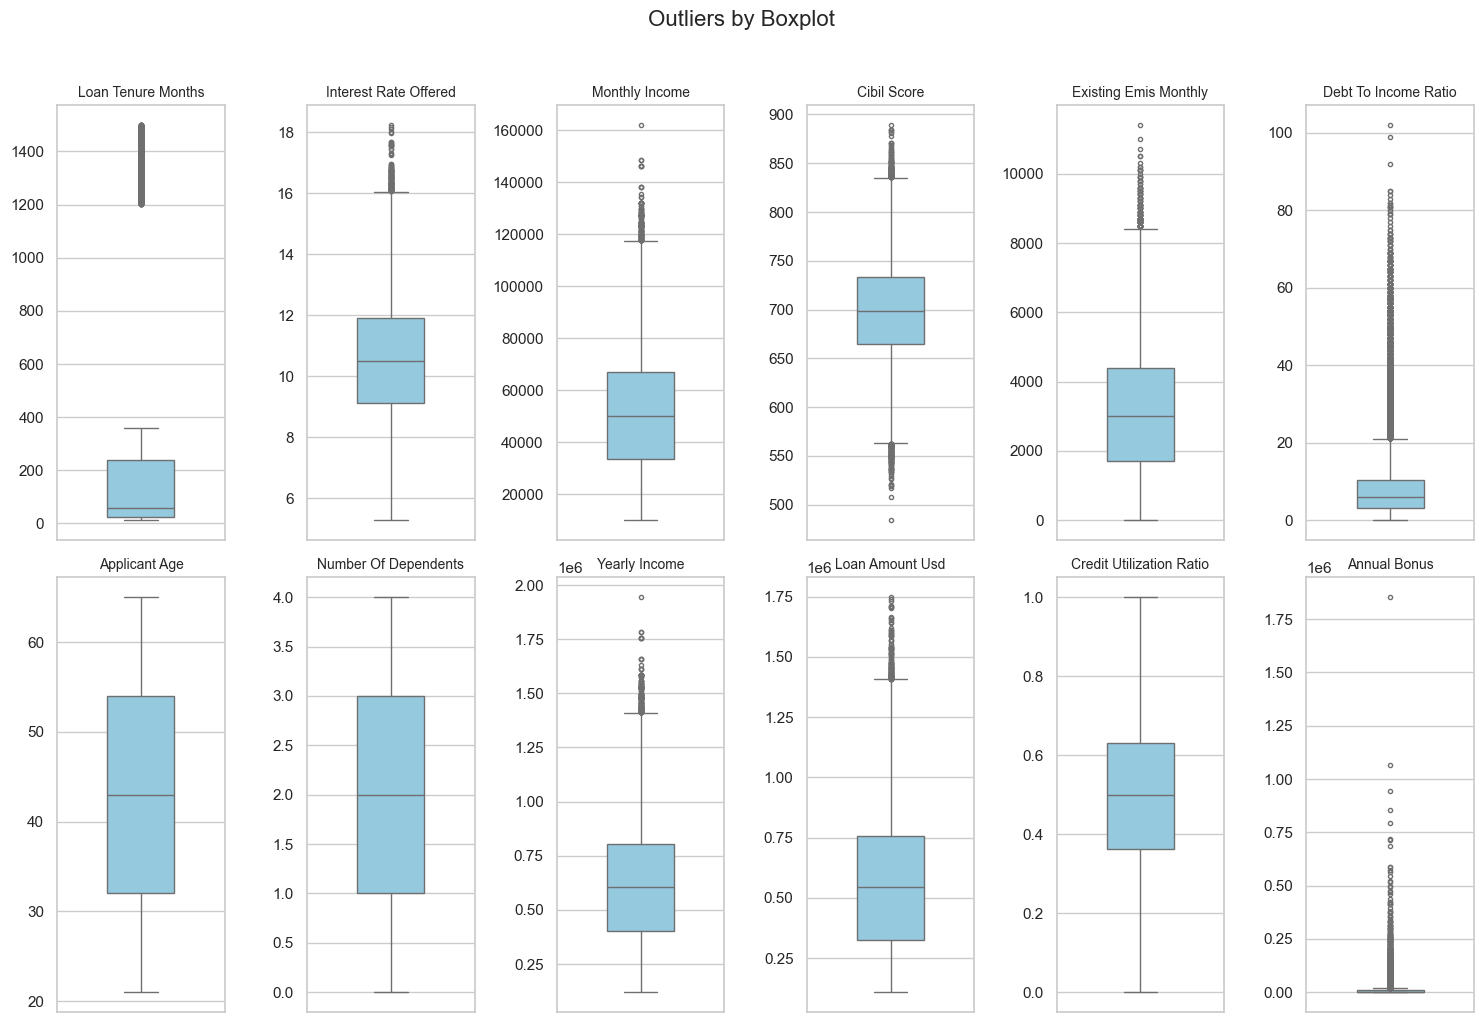

In [132]:
# defining subplots
fig, axes = plt.subplots(2, 6, figsize=(15, 10))
fig.suptitle('Outliers by Boxplot', fontsize=16, y=1.02)

# subplots
for ax, col in zip(axes.flatten(), numCols):
    sns.boxplot(data=df, y=col, ax=ax, width=0.4, color='skyblue', fliersize=3)
    ax.set_title(col.replace('_', ' ').title(), fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


In [133]:
# removing outliers by the loan tenure months
q1 = df['loan_tenure_months'].quantile(0.25)
q3 = df['loan_tenure_months'].quantile(0.75)
iqr = q3-q1
upperBound = q3 + iqr*1.5

# outliers
outliersDf = df[df['loan_tenure_months']>upperBound]

# removing outliers
df = df[df['loan_tenure_months']<=upperBound]

### Univariate

#### Loan Analysis: numerical data

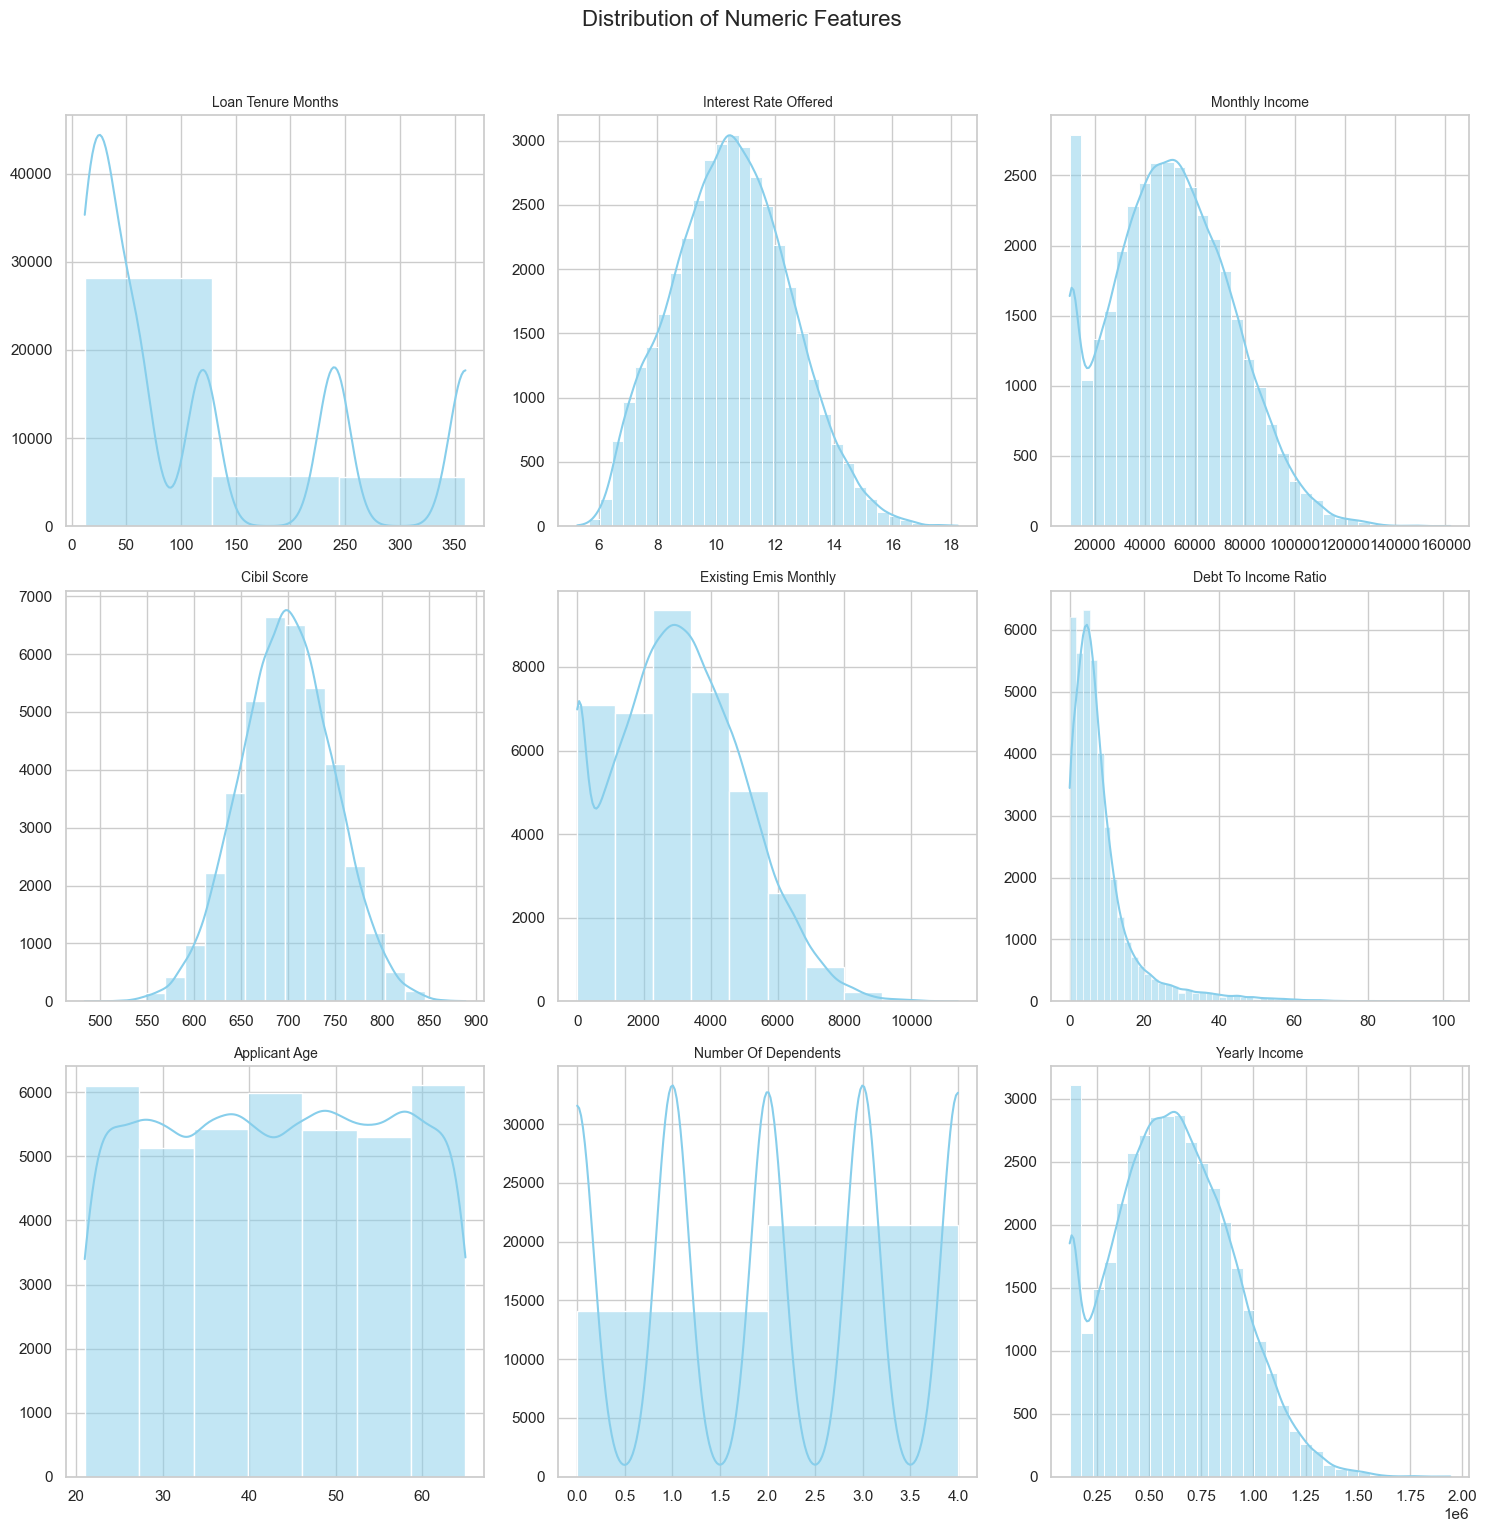

In [134]:
# defining subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Distribution of Numeric Features', fontsize=16, y=1.02)

# Loop pelas colunas e pelos eixos
for ax, col in zip(axes.flatten(), numCols):
    sns.histplot(data=df, x=col, ax=ax, kde=True, color='skyblue', bins=round((df[col].nunique()**0.5)))
    ax.set_title(col.replace('_', ' ').title(), fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


##### Categorical Data

In [135]:
def gender_label(row):
    if row['gender_Male'] == 1:
        return 'Man'
    elif row['gender_Other'] == 1:
        return 'Other'
    else:
        return 'Woman'

df['gender_label'] = df.apply(gender_label, axis=1)

In [136]:
def loan_type_label(row):
    if row['loan_type_Car Loan'] == 1:
        return 'Car'
    elif row['loan_type_Education Loan'] == 1:
        return 'Education'
    elif row['loan_type_Home Loan']==1:
        return 'Home'
    elif row['loan_type_Personal Loan']==1:
        return 'Personal'
    else:
        return 'Other'

df['loan_type_label'] = df.apply(loan_type_label, axis=1)

In [137]:
categCols = ['purpose_of_loan', 'employment_status', 'property_ownership_status', 'gender_label', 'loan_type_label']

for column in categCols:
    df[column]=df[column].str.capitalize()
    df[column]=df[column].str.strip()

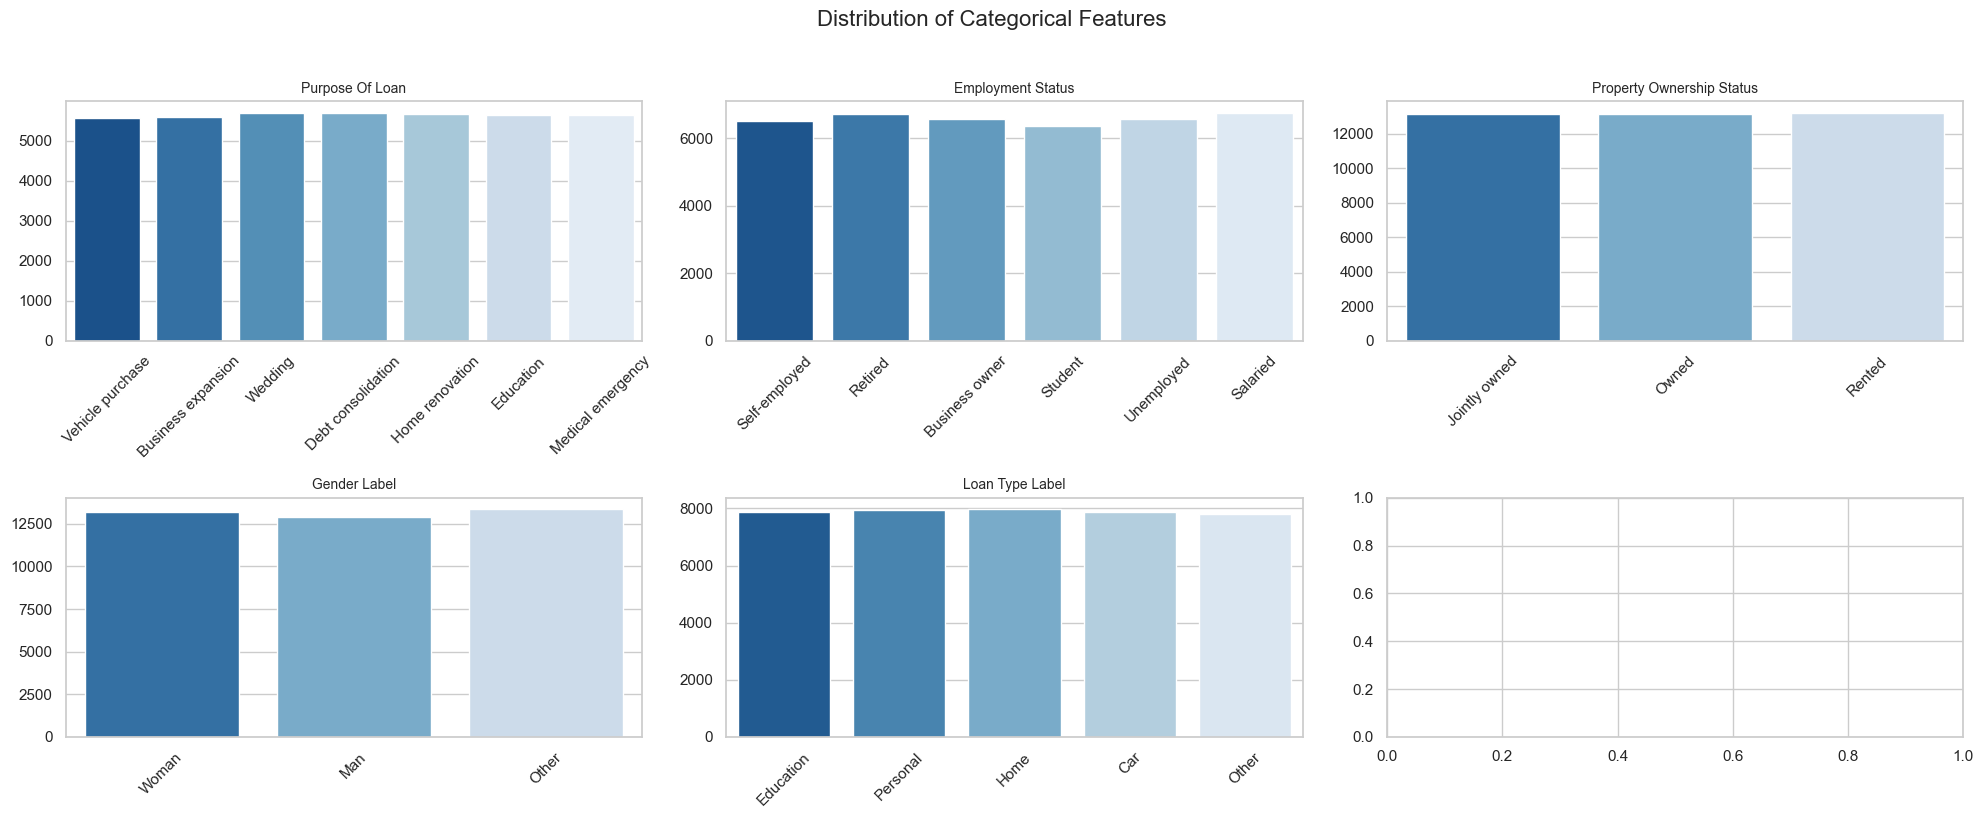

In [138]:
sns.set_theme(style="whitegrid")

# definindo subplots
fig, axes = plt.subplots(2,3, figsize=(20, 8))
fig.suptitle('Distribution of Categorical Features', fontsize=16, y=1.02)

# loop pelas colunas e pelos eixos
for ax, col in zip(axes.flatten(), categCols):
    sns.countplot(data=df, x=col, ax=ax, palette='Blues_r', hue=col, legend=False)
    ax.set_title(col.replace('_', ' ').title(), fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)  # gira os rótulos se forem longos

plt.tight_layout()
plt.show()

### Bivariate Analysis

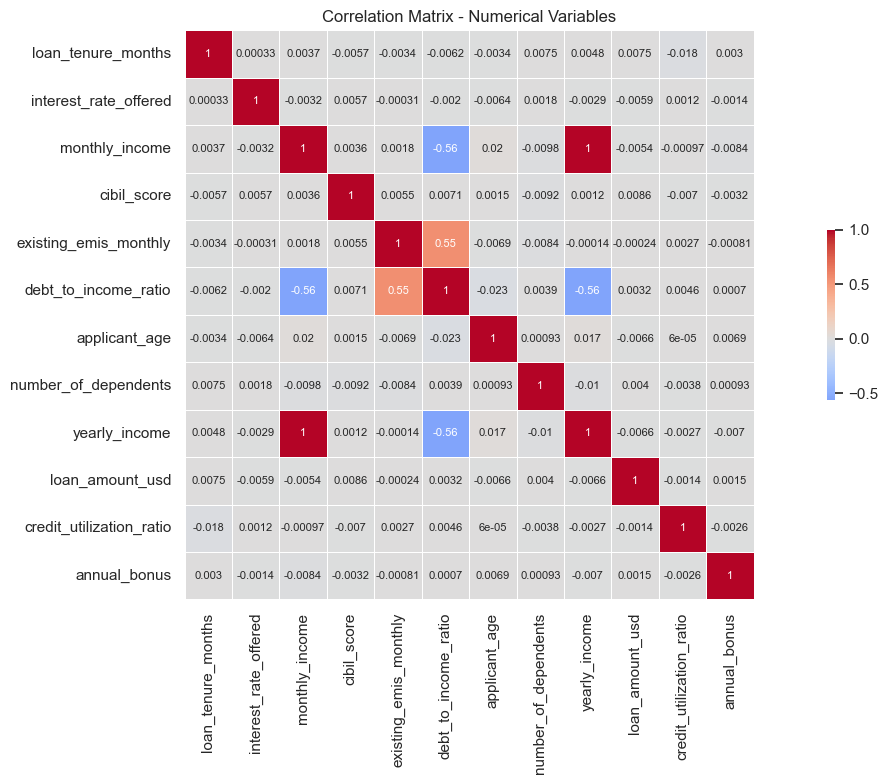

In [139]:
correlation_matrix = df[numCols].corr()

plt.figure(figsize=(15, 8)) 

sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm',
    center=0, 
    square=True, 
    linewidths=0.6, 
    cbar_kws={"shrink": .30},
    annot_kws={"size": 8}) 

plt.title('Correlation Matrix - Numerical Variables') 
plt.tight_layout()

### Fraud Analysis

In [140]:
# fraud proportion
fraudProportion = round(df[df['fraud_flag']==1].shape[0]/df.shape[0] * 100, 2)
print(f'We have {fraudProportion}% of fraud in the dataset')

We have 13.15% of fraud in the dataset


#### Checking Fraud and Categorical Variables Dependency

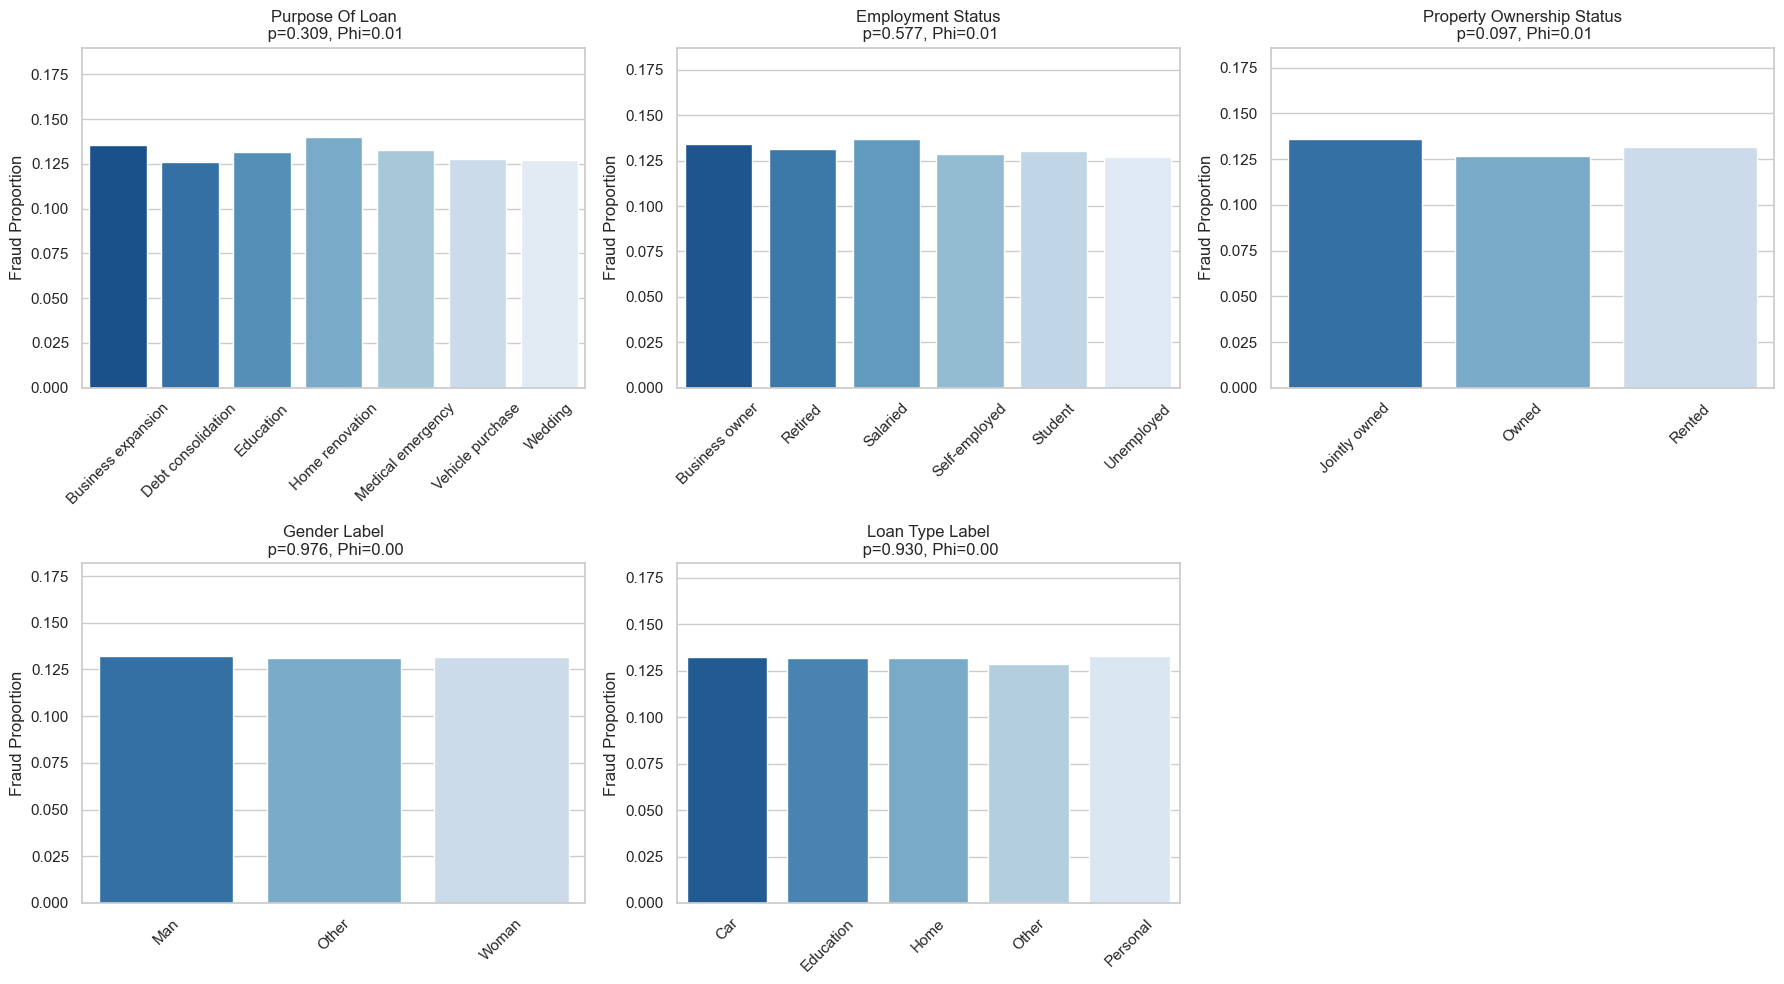

In [ ]:

plt.figure(figsize=(18, 10))
sns.set_theme(style="whitegrid")

for i, col in enumerate(categCols):
    # Contingency table
    contig_table = pd.crosstab(df[col], df['fraud_flag'])
    
    # Qui-square
    chi2, p, dof, expected = chi2_contingency(contig_table)
    phi = np.sqrt(chi2 / df.shape[0])
    
    # Frauds Proportion
    prop_df = df.groupby(col)['fraud_flag'].mean().reset_index()
    
    # Subplotting
    ax = plt.subplot(2, 3, i+1)  # i+1 porque subplot index começa em 1
    sns.barplot(x=col, y='fraud_flag', data=prop_df, palette='Blues_r', ax=ax, hue=col, legend=False)
    
    ax.set_title(f'{col.replace("_"," ").title()}\n p={p:.3f}, Phi={phi:.2f}', fontsize=12)
    ax.set_ylabel('Fraud Proportion')
    ax.set_xlabel('')
    ax.set_ylim(0, prop_df['fraud_flag'].max() + 0.05)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


None of the categorical variables has dependency with the Fraud (p-value > 5%)

In [166]:
df['year_application'] = df['application_date'].dt.year
df['month_application'] = df['application_date'].dt.month

dfFraudYear = (
    df
    .groupby(
        df['year_application'])
        .agg(
            applications=('fraud_flag', np.size), 
            frauds=('fraud_flag', np.sum))).reset_index()

dfFraudYear['fraud_proportion'] = dfFraudYear['frauds']/dfFraudYear['applications']*100
dfFraudYear

/var/folders/9l/mynyqp_x1qx1lcr2_jgyf1b40000gn/T/ipykernel_3768/2536791461.py:8: FutureWarning: The provided callable <function sum at 0x10a394180> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg(


,year_application,applications,frauds,fraud_proportion
0,2022,7614,991,13.015498
1,2023,13031,1701,13.053488
2,2024,13159,1745,13.260886
3,2025,5669,754,13.300406


In [168]:
dfFraudMonth = (
    df
    .groupby(
        ['year_application', 'month_application'])
        .agg(
            applications=('fraud_flag', np.size), 
            frauds=('fraud_flag', np.sum))).reset_index()

dfFraudMonth

/var/folders/9l/mynyqp_x1qx1lcr2_jgyf1b40000gn/T/ipykernel_3768/2704662004.py:5: FutureWarning: The provided callable <function sum at 0x10a394180> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg(


,year_application,month_application,applications,frauds
0,2022,6,953,138
1,2022,7,1130,165
2,2022,8,1122,136
3,2022,9,1047,133
4,2022,10,1116,157
5,2022,11,1113,130
6,2022,12,1133,132
7,2023,1,1092,133
8,2023,2,1038,141
9,2023,3,1079,139
